In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

load data

In [6]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y = pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

find shape of inputs and outputs

In [11]:
numFeatures = trainX.shape[1]
print('features', numFeatures)
numLabels = trainY.shape[1]
print('labels ', numLabels)

features 4
labels  3


In [12]:
trainX = tf.constant(trainX, dtype='float32')
trainY = tf.constant(trainY, dtype='float32')
testX = tf.constant(testX, dtype='float32')
testY = tf.constant(testY, dtype='float32')

2023-07-24 15:18:25.810634: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-24 15:18:25.810720: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-24 15:18:25.810736: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-24 15:18:25.811279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-24 15:18:25.811636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


How to determine weight and bias shapes:
* Input feature is of size 4 and output is of size 3. Weights will be [4,3]
* Output is size 3. Bias will be [3]

In [13]:
W = tf.Variable(tf.zeros([4,3]))
b = tf.Variable(tf.zeros([3]))

In [19]:
weights = tf.Variable(tf.random.normal([numFeatures,numLabels],
                                       mean=0.,
                                       stddev=0.01,
                                       name="weights"),dtype='float32')


bias = tf.Variable(tf.random.normal([1,numLabels],
                                    mean=0.,
                                    stddev=0.01,
                                    name="bias"))

In [21]:
def lr(x):
    applyWeights = tf.matmul(x,weights, name='apply_weights')
    addBias = tf.add(applyWeights, bias, name='add_bias')
    activation = tf.nn.sigmoid(addBias, name='activation')
    return activation

In [36]:
numEpochs = 1400
learningRate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0008, decay_steps=trainX.shape[0], decay_rate = 0.95, staircase=True)

In [31]:
lossfunction = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.legacy.SGD(learningRate)

In [32]:
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [33]:
def optimize(x,y):
    with tf.GradientTape() as g:
        pred = lr(x)
        loss = lossfunction(pred, y)
    gradients = g.gradient(loss,[weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

In [37]:
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1

for i in range(numEpochs):
    if i>1 and diff <.0001:
        print("change in loss %g; convergence."%diff)
        break
    else:
        # Run training step
        optimize(trainX, trainY)

        # Report occasional stats
        if i % display_step == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)

            pred = lr(testX)
            newLoss = lossfunction(pred, testY)
            loss_values.append(newLoss)

            acc = accuracy(pred, testY)
            accuracy_values.append(acc)

            diff = abs(newLoss - loss)
            loss = newLoss
            #generate print statements
            print("step %d, training accuracy %g, loss %g, change in loss %g"%(i, acc, newLoss, diff))


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %acc.numpy())

step 0, training accuracy 0.32, loss 0.11624, change in loss 0.11624
step 10, training accuracy 0.32, loss 0.116079, change in loss 0.000160985
step 20, training accuracy 0.32, loss 0.11592, change in loss 0.000158921
step 30, training accuracy 0.32, loss 0.115763, change in loss 0.000156879
step 40, training accuracy 0.32, loss 0.115609, change in loss 0.00015486
step 50, training accuracy 0.32, loss 0.115456, change in loss 0.000152849
step 60, training accuracy 0.32, loss 0.115305, change in loss 0.000150904
step 70, training accuracy 0.32, loss 0.115156, change in loss 0.000148982
step 80, training accuracy 0.32, loss 0.115009, change in loss 0.000147067
step 90, training accuracy 0.32, loss 0.114864, change in loss 0.000145182
step 100, training accuracy 0.32, loss 0.114727, change in loss 0.000136927
step 110, training accuracy 0.32, loss 0.114592, change in loss 0.000134565
step 120, training accuracy 0.32, loss 0.114459, change in loss 0.000132933
step 130, training accuracy 0.

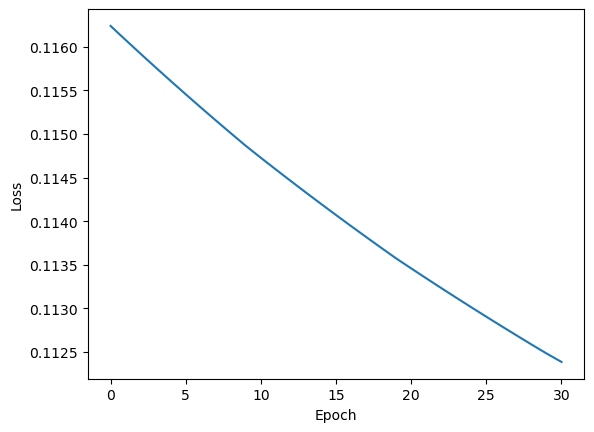

In [38]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values)
plt.show()